In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
import dataset
from dataset import SKDS, TVDS, CDataset

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms


In [ ]:
import numpy as np

class Dummy(CDataset):
    
    def load_data(self, boom='bust'):
        data = {1: (np.asarray([1,2,3,4]), np.asarray(100), ['apple','dog']),
                2: (np.asarray([5,6,7,8]), np.asarray(200), ['orange','cat'])}
        print(boom)
        return data
    
ds_params = {'train_params': {'embed': [('fruit',2,8,False,False),
                                        ('pet',2,8,False,False)],
                              'embed_lookup': {'fruit': {'apple': 1,
                                                         'orange': 2},
                                               'pet': {'dog': 1,
                                                       'cat': 2}},
             'boom': 'bang'}}
    
d = Dummy(**ds_params['train_params'])
d[1]           

In [ ]:
model_params = {'D_in': 256, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'embed': [],
                              'make': 'make_regression',
                              'transform': None,
                              'target_transform': None,
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=100)

In [ ]:
model_params = {'D_in': 256, 
                'H': 256, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'embed': [],
                              'make': 'make_classification',
                              'transform': transforms.Compose([dataset.AsTensor()]),
                              'target_transform': transforms.Compose(
                                                      [dataset.DType('int64'),
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()]),
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=100)

TVDS created...
TVDS created...
TorchVision model resnet18 loaded...
learning time: 0:01:59.398025
epoch: 0, lr: 0.01
train loss: 0.30337667279783637, val loss: 0.08396614395221447
sk_metric: 
0.9995626703309709
learning time: 0:03:59.003484
epoch: 1, lr: 0.01
train loss: 0.06319380879122764, val loss: 0.06383044035223756
sk_metric: 
0.9996025604273706
test loss: 0.045962960774676716
learning time: 0:04:06.409795
sklean metric: 
0.9998590257831486 



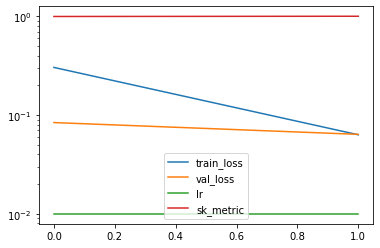

In [3]:
model_params = {'model_name': 'resnet18',
                'in_channels': 1,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'embed': [],
                            'dataset': 'MNIST',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.Resize(224),
                                                           transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'embed': [],
                           'dataset': 'MNIST',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(224),
                                                         transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.8,)}
sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=64, epochs=2)